# Model-validation (Cross-validation)

Every statistical or machine learning model need to be validated, which is called [statistical model validation](https://en.wikipedia.org/wiki/Statistical_model_validation), before used in real world or production. This means testing the model against never seen before data (out of sample data) and comparing the predictions with dataset results. 

- k-fold cross-validation
- stratified k-fold cross-validation
- hold-out based validation
- leave-one-out cross-validation
- group k-fold cross-validation

In this section, we will use [Wine Quality Dataset](https://archive.ics.uci.edu/ml/datasets/wine+quality).

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utilities import create_folds

sns.set_theme()


Let's load the data, wine quality dataset, and check what kind of features we have:

In [27]:
df = pd.read_csv("data/winequality-red.csv")
df_org = df.copy(deep=True)
mapping = {3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5}

df.quality = df.quality.map(mapping)
print(f"Data type: {df.dtypes}")
df.head()

Data type: fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2


We don't have any categorical features and target variable is `quality`. We can map this to a more easily interpretable values.

In [37]:
from sklearn.model_selection import train_test_split


X = df.drop("quality", axis=1).values
y = df.quality

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, test_size=0.2, stratify=y, random_state=42
)


## Overfitting

Fine tuning the model to a specific dataset instead of generalizing to underlying distribution of population from which dataset comes from. However, overfitting is a muddy concept and the definition given is far from being a consensus. So to be practical, in quantitative terms, overfitting starts to occur while training error decreases, validation error increases.

Best test accuracy is 0.625 
Optimum depth is 23


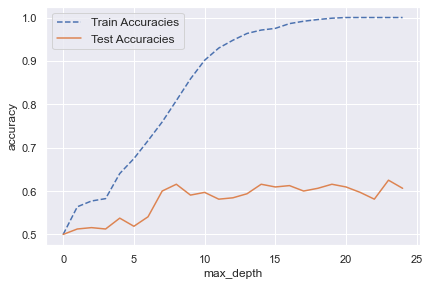

In [29]:
from sklearn import tree
from sklearn import metrics

fig_cv, ax = plt.subplots(figsize=(6,4))
fig_cv.tight_layout()


train_accuracies = [0.5]
test_accuracies = [0.5]

depths = list(range(1,25))

for depth in depths:
    
    decision_tree = tree.DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train, y_train)
    
    train_accuracy = decision_tree.score(X_train, y_train)
    train_accuracies.append(train_accuracy)
    
    test_accuracy = decision_tree.score(X_test, y_test)
    test_accuracies.append(test_accuracy)
    

print("Best test accuracy is", max(test_accuracies), "\nOptimum depth is",
      test_accuracies.index(max(test_accuracies)))

ax.plot(train_accuracies, label="Train Accuracies", linestyle="dashed")
ax.plot(test_accuracies, label="Test Accuracies")
ax.legend(loc="upper left", prop={"size":12})
ax.set_xlabel("max_depth")
ax.set_ylabel("accuracy")
plt.show()

Splitting data into train and test set is called **holdout validation**. We train the data on train set and check the accuracy on test set. The reason you are getting a different result from the book is that `sample` method chooses datapoints randomly unless given a `random_state` parameter. The book does not declare a specific random state. However, here we use `sklearn` method with a given explicit `random_state`.

So far sampling procedure (`wine_df.sample(frac=1)`) did not take into account the distribution of datapoints. We have 6 different quality of wines and ideally distributions of trainingset and testset data points should mimic the entire dataset. Let's check the distributions of all sets. As you can see they are pretty similar, so we can say training set and test set are representative of whole dataset in terms of `quality` (target) variable.

In [33]:
trainset_dist

1    0.0375
2    0.5075
3    0.3550
4    0.0925
5    0.0075
Name: quality, dtype: float64

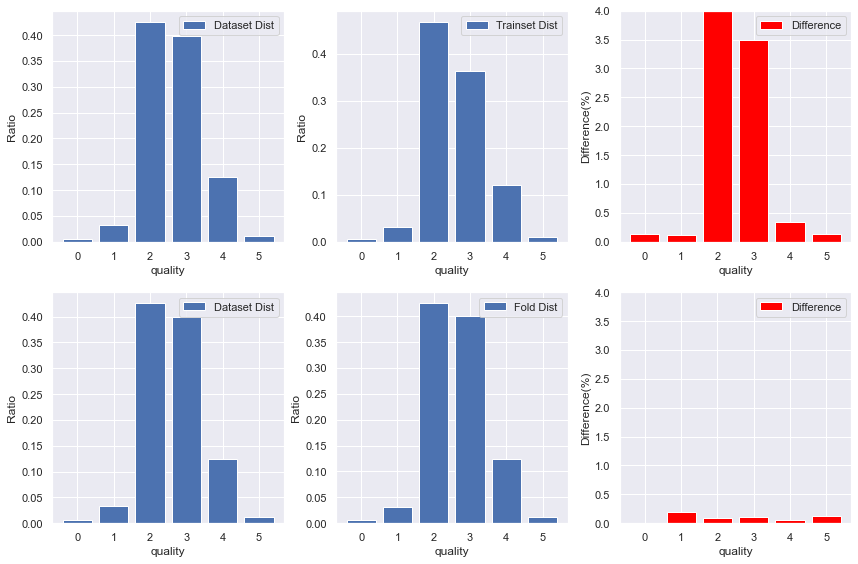

In [38]:
wine_fold = create_folds(df, "quality")
index = wine_fold["kfold"] == 1
wine_fold_1 = wine_fold.loc[index,:]
wine_train_df = df.iloc[:1000,:]

dataset_dist = df.quality.value_counts().sort_index() / len(df)
trainset_dist = wine_train_df.quality.value_counts().sort_index() / len(wine_train_df)
winefold_dist = wine_fold_1.quality.value_counts().sort_index().values / len(wine_fold_1)

quality_index = [x for x in range(6)]


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(12,8))

ax1.bar(quality_index, dataset_dist, label="Dataset Dist")
ax1.legend()
ax1.set_xticks(quality_index)
ax1.set_xlabel("quality")
ax1.set_ylabel("Ratio")

ax2.bar(quality_index,trainset_dist, label="Trainset Dist")
ax2.set_xticks(quality_index)
ax2.legend()
ax2.set_xlabel("quality")
ax2.set_ylabel("Ratio")

ax3.bar(quality_index,abs(trainset_dist - dataset_dist)*100, label="Difference", color="red")
ax3.set_xticks(quality_index)
ax3.legend()
ax3.set_xlabel("quality")
ax3.set_ylabel("Difference(%)")
ax3.set_ylim(0,4)

ax4.bar(quality_index,dataset_dist, label="Dataset Dist")
ax4.legend()
ax4.set_xticks(quality_index)
ax4.set_xlabel("quality")
ax4.set_ylabel("Ratio")

ax5.bar(quality_index,winefold_dist, label="Fold Dist")
ax5.set_xticks(quality_index)
ax5.legend()
ax5.set_xlabel("quality")
ax5.set_ylabel("Ratio")

ax6.bar(quality_index,abs(winefold_dist - dataset_dist)*100, label="Difference", color="red")
ax6.set_xticks(quality_index)
ax6.legend()
ax6.set_xlabel("quality")
ax6.set_ylabel("Difference(%)")
ax6.set_ylim(0,4)

fig.tight_layout()

In [21]:
from sklearn import datasets
from sklearn import model_selection


X, y = datasets.make_regression(n_samples=1500, n_features=100,n_targets=1, random_state=40)

df = pd.DataFrame(data=X, columns=[f"x{i}" for i in range(X.shape[1])])

df.loc[:,"target"] = y
df = create_folds(df,"target",binning=True)


/home/onur/companions/aaamlp/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


- why the warning above  is shown? Because the last bin has less data points than 5. Let's count how many data points each bin has:

In [22]:
df.loc[:,"bins"] = pd.cut(df["target"], bins=11, labels=False) # 11 comes from Sturge's law
bin_count = {}
for i in range(11):
    index = df["bins"] == i
    bin_count[f"{i}.Bin"] = len(df[index])
    #bin_count.append(len(df[index]))
bin_count

{'0.Bin': 20,
 '1.Bin': 50,
 '2.Bin': 144,
 '3.Bin': 246,
 '4.Bin': 325,
 '5.Bin': 325,
 '6.Bin': 228,
 '7.Bin': 115,
 '8.Bin': 36,
 '9.Bin': 9,
 '10.Bin': 2}